# Building a Generalized Nuclear Model

In [1]:
import os
import errno

import numpy as np

import deepcell

Using TensorFlow backend.


## Load Each Dataset

In [2]:
# Download the data (saves to ~/.keras/datasets)
hela_filename = 'HeLa_S3.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(hela_filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (6208, 216, 256, 1)
y.shape: (6208, 216, 256, 1)


In [3]:
# Download the data (saves to ~/.keras/datasets)
hek_filename = 'HEK293.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hek293.load_data(hek_filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (9192, 135, 160, 1)
y.shape: (9192, 135, 160, 1)


In [4]:
# Download the data (saves to ~/.keras/datasets)
nih_filename = '3T3_NIH.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.nih_3t3.load_data(nih_filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 954b6f4ad6a71435b84c40726837e4ba so we will re-download the data.
1937301504/1937295810 [==============================] - 87s 0us/step
X.shape: (230, 30, 154, 182, 1)
y.shape: (230, 30, 154, 182, 1)


### Flatten All Datasets into 2D and Combine

In [5]:
# Load the data with get_data function
from deepcell.utils.data_utils import get_data

def get_path(fname):
    path = os.path.join('~', '.keras', 'datasets', fname)
    return os.path.expanduser(path)

hela_train, hela_test = get_data(get_path(hela_filename))

hek_train, hek_test = get_data(get_path(hek_filename))

nih_train, nih_test = get_data(get_path(nih_filename))

In [6]:
def count_cells(train, test, name):
    y = np.vstack([train['y'], test['y']])
    if len(y.shape) == 5:
        y_reshape = np.resize(y, (y.shape[0] * y.shape[1], *y.shape[2:]))
    else:
        y_reshape = y

    total_cells = 0
    for i in range(y_reshape.shape[0]):
        unique = np.unique(y_reshape[i])
        total_cells += (len(unique) - 1)
    print('{} Total {} Cells'.format(total_cells, name))

count_cells(nih_train, nih_test, '3T3_NIH')
count_cells(hek_train, hek_test, 'HEK293')
count_cells(hela_train, hela_test, 'HeLa_S3')

82066 Total 3T3_NIH Cells
193840 Total HEK293 Cells
55190 Total HeLa_S3 Cells


In [7]:
# flatten the NIH dataset as it is 3D
def flatten(d):
    return np.resize(d, tuple([d.shape[0] * d.shape[1]] + list(d.shape[2:])))

nih_train['X'] = flatten(nih_train['X'])
nih_train['y'] = flatten(nih_train['y'])
nih_test['X'] = flatten(nih_test['X'])
nih_test['y'] = flatten(nih_test['y'])

In [8]:
# Now reshape the dat aso that they all have the same x/y dimensions
from deepcell.utils.data_utils import reshape_matrix

RESHAPE_SIZE = 128
                       
hela_train['X'], hela_train['y'] = reshape_matrix(hela_train['X'], hela_train['y'], RESHAPE_SIZE)
hela_test['X'], hela_test['y'] = reshape_matrix(hela_test['X'], hela_test['y'], RESHAPE_SIZE)

hek_train['X'], hek_train['y'] = reshape_matrix(hek_train['X'], hek_train['y'], RESHAPE_SIZE)
hek_test['X'], hek_test['y'] = reshape_matrix(hek_test['X'], hek_test['y'], RESHAPE_SIZE)

nih_train['X'], nih_train['y'] = reshape_matrix(nih_train['X'], nih_train['y'], RESHAPE_SIZE)
nih_test['X'], nih_test['y'] = reshape_matrix(nih_test['X'], nih_test['y'], RESHAPE_SIZE)

Reshaped feature data from (6984, 216, 256, 1) to (27936, 128, 128, 1)
Reshaped training data from (6984, 216, 256, 1) to (27936, 128, 128, 1)
Reshaped feature data from (776, 216, 256, 1) to (3104, 128, 128, 1)
Reshaped training data from (776, 216, 256, 1) to (3104, 128, 128, 1)
Reshaped feature data from (10341, 135, 160, 1) to (41364, 128, 128, 1)
Reshaped training data from (10341, 135, 160, 1) to (41364, 128, 128, 1)
Reshaped feature data from (1149, 135, 160, 1) to (4596, 128, 128, 1)
Reshaped training data from (1149, 135, 160, 1) to (4596, 128, 128, 1)
Reshaped feature data from (7770, 154, 182, 1) to (31080, 128, 128, 1)
Reshaped training data from (7770, 154, 182, 1) to (31080, 128, 128, 1)
Reshaped feature data from (870, 154, 182, 1) to (3480, 128, 128, 1)
Reshaped training data from (870, 154, 182, 1) to (3480, 128, 128, 1)


In [9]:
# Stack up our data as train and test
X_train = np.vstack([hela_train['X'], hek_train['X'], nih_train['X']])
y_train = np.vstack([hela_train['y'], hek_train['y'], nih_train['y']])

X_test = np.vstack([hela_test['X'], hek_test['X'], nih_test['X']])
y_test = np.vstack([hela_test['y'], hek_test['y'], nih_test['y']])

In [10]:
# Load the data into a tensors as X and y
X = np.vstack([X_train, X_test])
y = np.vstack([y_train, y_test])

In [11]:
# Set up filepath constants

# change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

# filename to write combined data
filename = 'general_nuclear_data.npz'

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)

# the path to the data file is currently required for `train_model_()` functions
np.savez(DATA_FILE, X=X, y=y)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [12]:
# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

## Train a General Nuclear Model

### Set up Training Parameters

In [13]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'fgbg_nuclear_model'
conv_model_name = 'watershed_nuclear_model'

n_epoch = 3  # Number of training epochs
test_size = .20  # % of data saved as test
norm_method = 'std'  # data normalization
receptive_field = 41  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 0  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'watershed'
distance_bins = 4
erosion_width = 0  # erode edges

### First, create a foreground/background separation model

#### Instantiate the fgbg model

In [14]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple(X_train.shape[1:]))

#### Train the model fgbg model

In [15]:
from deepcell.training import train_model_conv

fgbg_model = train_model_conv(
    model=fgbg_model,
    dataset=DATA_FILE,  # full path to npz file
    model_name=fgbg_model_name,
    test_size=test_size,
    optimizer=optimizer,
    n_epoch=n_epoch,
    batch_size=batch_size,
    transform='fgbg',
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (89248, 128, 128, 1)
y_train shape: (89248, 128, 128, 1)
X_test shape: (22312, 128, 128, 1)
y_test shape: (22312, 128, 128, 1)
Output Shape: (None, 128, 128, 2)
Number of Classes: 2
Training on 1 GPUs
Epoch 1/3
89246/89248 [============================>.] - ETA: 0s - loss: 0.1527 - acc: 0.9410
Epoch 00001: val_loss improved from inf to 0.15587, saving model to /data/models/fgbg_nuclear_model.h5
89248/89248 [==============================] - 1664s 19ms/step - loss: 0.1527 - acc: 0.9410 - val_loss: 0.1559 - val_acc: 0.9462
Epoch 2/3
89246/89248 [============================>.] - ETA: 0s - loss: 0.1439 - acc: 0.9429
Epoch 00002: val_loss improved from 0.15587 to 0.15583, saving model to /data/models/fgbg_nuclear_model.h5
89248/89248 [==============================] - 1650s 18ms/step - loss: 0.1439 - acc: 0.9429 - val_loss: 0.1558 - val_acc: 0.9417
Epoch 3/3
89247/89248 [============================>.] - ETA: 0s - loss: 0.1411 - acc: 0.9435
Epoch 00003: val_loss did not impr

### Next, Create a model for the watershed energy transform

#### Instantiate the distance transform model

In [16]:
from deepcell import model_zoo

watershed_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple(X_train.shape[1:]))

#### Train the distance transform model

In [17]:
from deepcell.training import train_model_conv

watershed_model = train_model_conv(
    model=watershed_model,
    dataset=DATA_FILE,  # full path to npz file
    model_name=conv_model_name,
    test_size=test_size,
    optimizer=optimizer,
    n_epoch=n_epoch,
    batch_size=batch_size,
    transform=transform,
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (89248, 128, 128, 1)
y_train shape: (89248, 128, 128, 1)
X_test shape: (22312, 128, 128, 1)
y_test shape: (22312, 128, 128, 1)
Output Shape: (None, 128, 128, 4)
Number of Classes: 4
Training on 1 GPUs
Epoch 1/3
89246/89248 [============================>.] - ETA: 0s - loss: 0.5592 - acc: 0.8675
Epoch 00001: val_loss improved from inf to 0.61912, saving model to /data/models/watershed_nuclear_model.h5
89248/89248 [==============================] - 2268s 25ms/step - loss: 0.5592 - acc: 0.8675 - val_loss: 0.6191 - val_acc: 0.8306
Epoch 2/3
89246/89248 [============================>.] - ETA: 0s - loss: 0.5349 - acc: 0.8760
Epoch 00002: val_loss improved from 0.61912 to 0.61819, saving model to /data/models/watershed_nuclear_model.h5
89248/89248 [==============================] - 2264s 25ms/step - loss: 0.5349 - acc: 0.8760 - val_loss: 0.6182 - val_acc: 0.8353
Epoch 3/3
89247/89248 [============================>.] - ETA: 0s - loss: 0.5256 - acc: 0.8787
Epoch 00003: val_loss im

## Run the Model

In [18]:
from timeit import default_timer

start = default_timer()
test_images = watershed_model.predict(X_test)
print('watershed transform shape:', test_images.shape)
watershed_time = default_timer() - start
print('segmented in', watershed_time, 'seconds')

start = default_timer()
test_images_fgbg = fgbg_model.predict(X_test)
print('segmentation mask shape:', test_images_fgbg.shape)
fgbg_time = default_timer() - start
print('segmented in', fgbg_time, 'seconds')

watershed transform shape: (11180, 128, 128, 4)
segmented in 33.98737014224753 seconds
segmentation mask shape: (11180, 128, 128, 2)
segmented in 17.093125076964498 seconds


In [19]:
test_images = watershed_model.predict(X_test)
test_images_fgbg = fgbg_model.predict(X_test)

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

watershed transform shape: (11180, 128, 128, 4)
segmentation mask shape: (11180, 128, 128, 2)
watershed argmax shape: (11180, 128, 128, 1)


In [20]:
# threshold the foreground/background
# and remove back ground from watershed transform
threshold = 0.5
fg_thresh = test_images_fgbg[..., 1] > threshold
fg_thresh = test_images[..., 1] + test_images[..., 2] + test_images[..., 3] > threshold

fg_thresh = np.expand_dims(fg_thresh, axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [21]:
# Apply watershed method with the distance transform as seed
from scipy import ndimage
from scipy.ndimage.morphology import distance_transform_edt
from skimage.morphology import watershed, opening, closing
from skimage.feature import peak_local_max
from skimage.morphology import erosion, ball

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(
        test_images[i, ..., -1],
        min_distance=10,
        threshold_abs=0.05,
        indices=False,
        labels=image,
        exclude_border=False)

    markers = ndimage.label(local_maxi)[0]
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=-1)

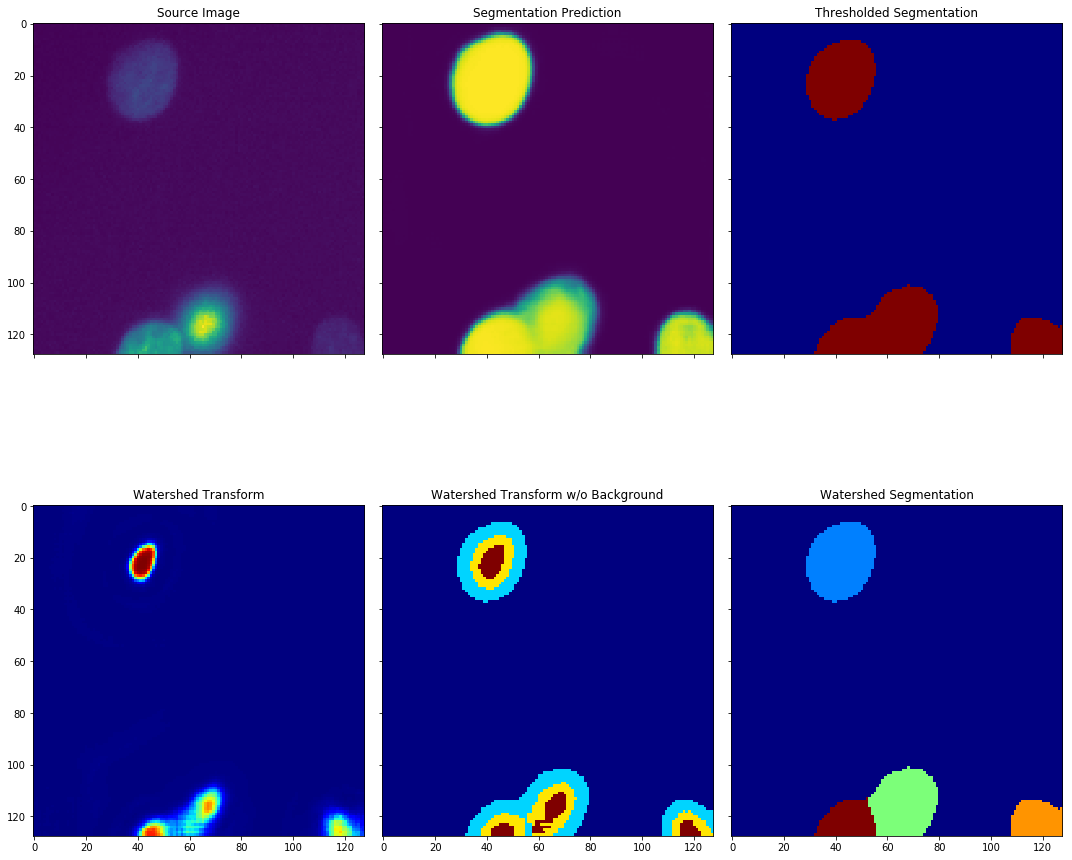

In [22]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

index = 1000

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, :, :, 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, :, :, 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, :, :, 0], cmap='jet')
ax[2].set_title('Thresholded Segmentation')

ax[3].imshow(test_images[index, :, :, 3], cmap='jet')
ax[3].set_title('Watershed Transform')

ax[4].imshow(argmax_images_post_fgbg[index, :, :, 0], cmap='jet')
ax[4].set_title('Watershed Transform w/o Background')

ax[5].imshow(watershed_images[index, :, :, 0], cmap='jet')
ax[5].set_title('Watershed Segmentation')

fig.tight_layout()
plt.show()

## Export the Model for TensorFlow-Serving

In [23]:
from deepcell import model_zoo
from tensorflow.keras import backend as K

K.set_floatx('float16')

# re-instantiate with a new input_shape
fgbg_model_f16 = model_zoo.bn_feature_net_skip_2D(
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=2,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=(128, 128, 1))
fgbg_model_f16.load_weights(os.path.join(MODEL_DIR, fgbg_model_name + '.h5'))

watershed_model_f16 = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model_f16,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=(128, 128, 1))
watershed_model_f16.load_weights(os.path.join(MODEL_DIR, conv_model_name + '.h5'))

In [24]:
from timeit import default_timer

start = default_timer()
test_images_16 = watershed_model_f16.predict(X_test)
print('watershed transform shape:', test_images_16.shape)
_watershed_time = default_timer() - start
print('float16 time is', _watershed_time, 'seconds')
print('float32 time was', watershed_time, 'seconds')

start = default_timer()
test_images_fgbg_16 = fgbg_model_f16.predict(X_test)
print('segmentation mask shape:', test_images_fgbg_16.shape)
_fgbg_time = default_timer() - start
print('float16 time is', _fgbg_time, 'seconds')
print('float32 time was', fgbg_time, 'seconds')

watershed transform shape: (11180, 128, 128, 4)
float16 time is 24.75052117696032 seconds
float32 time was 33.98737014224753 seconds
segmentation mask shape: (11180, 128, 128, 2)
float16 time is 13.481910694856197 seconds
float32 time was 17.093125076964498 seconds


In [26]:
from deepcell.utils.export_utils import export_model

weights_path = os.path.join(MODEL_DIR, conv_model_name + '.h5')

EXPORT_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'exports', PREFIX))
export_path = os.path.join(EXPORT_DIR, conv_model_name)

export_model(watershed_model_f16, export_path,
             model_version=1, weights_path=weights_path)

assert os.path.isdir(export_path)

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /data/exports/watershed_nuclear_model/1/saved_model.pb
